# Exploratory Analysis: Media + Reddit Sentence Data


In [1]:
from __future__ import annotations

import json
from collections import Counter
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional

import pandas as pd

import matplotlib.pyplot as plt




def _ensure_list(value: Any) -> List[Any]:
    if value is None:
        return []
    if isinstance(value, list):
        return value
    if isinstance(value, str):
        s = value.strip()
        if not s:
            return []
        # Best-effort: support older "a; b; c" style.
        if ";" in s:
            return [p.strip() for p in s.split(";") if p.strip()]
        return [s]
    return [value]


def load_jsonl(path: Path, *, source: str) -> pd.DataFrame:
    records: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue
            if not isinstance(obj, dict):
                continue
            if obj.get("_type") == "url_done":
                continue
            obj = dict(obj)
            obj["source"] = source
            obj["input_path"] = str(path)
            records.append(obj)
    return pd.DataFrame.from_records(records)


def load_grouped_json(path: Path, *, source: str) -> pd.DataFrame:
    payload = json.loads(path.read_text(encoding="utf-8-sig"))
    if not isinstance(payload, dict):
        raise ValueError(f"Expected dict at top-level for grouped JSON: {path}")

    records: List[Dict[str, Any]] = []
    for player, items in payload.items():
        if player == "_meta":
            continue
        if not isinstance(items, list):
            continue
        for item in items:
            if isinstance(item, str):
                rec: Dict[str, Any] = {"player": str(player), "sentence": item}
            elif isinstance(item, dict):
                rec = {"player": str(player), **item}
            else:
                continue
            rec["source"] = source
            rec["input_path"] = str(path)
            records.append(rec)

    return pd.DataFrame.from_records(records)


def load_any(path: Path, *, source: str) -> pd.DataFrame:
    if path.suffix.lower() == ".jsonl":
        return load_jsonl(path, source=source)
    if path.suffix.lower() == ".json":
        return load_grouped_json(path, source=source)
    raise ValueError(f"Unsupported input file type: {path}")


def normalize_frame(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    df = df.copy()
    if "sentence" not in df.columns:
        df["sentence"] = ""
    if "player" not in df.columns:
        df["player"] = ""

    df["sentence"] = df["sentence"].fillna("").astype(str)
    df["player"] = df["player"].fillna("").astype(str)

    for col in ["players", "other_persons"]:
        if col not in df.columns:
            df[col] = [[] for _ in range(len(df))]
        df[col] = df[col].apply(_ensure_list)

    df["n_players_mentioned"] = df["players"].apply(len)
    df["n_other_persons"] = df["other_persons"].apply(len)
    df["sentence_len_words"] = df["sentence"].str.split().apply(len)
    df["sentence_len_chars"] = df["sentence"].str.len()
    df["has_other_person"] = df["n_other_persons"] > 0
    df["has_multiple_tracked_players"] = df["n_players_mentioned"] > 1

    if "tie_breaker" in df.columns:
        df["tie_breaker"] = df["tie_breaker"].fillna("").astype(str)
        df["is_pronoun_backfill"] = df["tie_breaker"] == "pronoun_backfill"
    else:
        df["is_pronoun_backfill"] = False

    return df


def summarize(df: pd.DataFrame, name: str) -> None:
    print(f"=== {name} ===")
    print(f"rows: {len(df):,}")
    if df.empty:
        return
    print(f"unique players: {df['player'].nunique():,}")
    print(f"unique sentences: {df['sentence'].nunique():,}")

    share_other = float(df['has_other_person'].mean())
    share_multi = float(df['has_multiple_tracked_players'].mean())
    print(f"share with other_persons: {share_other:.1%}")
    print(f"share with multiple tracked players: {share_multi:.1%}")

    if df['is_pronoun_backfill'].any() or 'tie_breaker' in df.columns:
        print("tie_breaker counts:")
        if 'tie_breaker' in df.columns:
            print(df['tie_breaker'].value_counts(dropna=False).head(20))
        else:
            print(df['is_pronoun_backfill'].value_counts(dropna=False))


def top_other_persons(df: pd.DataFrame, n: int = 30) -> pd.DataFrame:
    c: Counter[str] = Counter()
    for lst in df.get('other_persons', []):
        for person in lst:
            p = str(person).strip()
            if p:
                c[p] += 1
    return pd.DataFrame(c.most_common(n), columns=['other_person', 'count'])


def top_pairs(df: pd.DataFrame, n: int = 50) -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    for _, r in df.iterrows():
        player = str(r.get('player', '')).strip()
        for other in r.get('other_persons', []):
            other_s = str(other).strip()
            if player and other_s:
                rows.append({'player': player, 'other_person': other_s})
    if not rows:
        return pd.DataFrame(columns=['player', 'other_person', 'count'])
    pairs = pd.DataFrame(rows)
    out = (
        pairs.groupby(['player', 'other_person'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .head(n)
    )
    return out


In [2]:

# Media sentence data (JSONL or grouped JSON)
MEDIA_INPUTS = [
    Path('data/media_data/media_pronoun_run.jsonl'),
]

# Reddit sentence data (JSONL or grouped JSON)
REDDIT_INPUTS = [
    Path('data/reddit_data/reddit_player_sentences_by_player_200-40-10-40-5.jsonl'),
]

# If you combined multiple runs/files, dedupe to avoid double-counting.
DEDUPE = True
DEDUPE_KEYS = ['source', 'player', 'sentence']  # add 'url' if you want URL-sensitive dedupe


In [3]:
def load_many(paths: Iterable[Path], *, source: str) -> pd.DataFrame:
    dfs: List[pd.DataFrame] = []
    loaded: List[str] = []
    for p in paths:
        if not p.exists():
            continue
        df = load_any(p, source=source)
        if not df.empty:
            dfs.append(df)
            loaded.append(str(p))
    print(f"Loaded {len(loaded)} {source} file(s):")
    for s in loaded:
        print('  -', s)
    if not dfs:
        return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)


media_raw = load_many(MEDIA_INPUTS, source='media')
reddit_raw = load_many(REDDIT_INPUTS, source='reddit')

media = normalize_frame(media_raw)
reddit = normalize_frame(reddit_raw)

all_df = pd.concat([media, reddit], ignore_index=True)
all_df = normalize_frame(all_df)

if DEDUPE and not all_df.empty:
    keys = [k for k in DEDUPE_KEYS if k in all_df.columns]
    before = len(all_df)
    all_df = all_df.drop_duplicates(subset=keys)
    print(f"Deduped: {before:,} -> {len(all_df):,} (keys={keys})")

media = all_df[all_df['source'] == 'media'].copy()
reddit = all_df[all_df['source'] == 'reddit'].copy()


Loaded 1 media file(s):
  - data\media_data\media_pronoun_run.jsonl
Loaded 1 reddit file(s):
  - data\reddit_data\reddit_player_sentences_by_player_200-40-10-40-5.jsonl
Deduped: 37,477 -> 34,106 (keys=['source', 'player', 'sentence'])


In [4]:
summarize(media, 'MEDIA')
print()
summarize(reddit, 'REDDIT')


=== MEDIA ===
rows: 26,011
unique players: 66
unique sentences: 25,878
share with other_persons: 42.5%
share with multiple tracked players: 4.8%
tie_breaker counts:
tie_breaker
pronoun_backfill                          16789
single_player                              7977
longest_alias_then_count_then_position     1245
Name: count, dtype: int64

=== REDDIT ===
rows: 8,095
unique players: 51
unique sentences: 7,968
share with other_persons: 17.8%
share with multiple tracked players: 2.8%
tie_breaker counts:
tie_breaker
    8095
Name: count, dtype: int64


Media dominates 26,011 rows vs 8,095 Reddit rows.
We do not plan to combine reddit and media so no problem we were just able to get more relevant links from the media outlets though they are more prone to be not related to the nba players as the websearch might have gone wrong, for example name of a player is name of other person so it got matched we do not check explicitly whether the article is basketball related

,player,sentences
0,Chris Paul,1805
1,Jeff Green,1514
2,Shai Gilgeous-Alexander,1495
3,Aaron Holiday,1265
4,Bruce Brown,1253
...,...,...
61,Josh Minott,41
62,Drew Eubanks,28
63,Dorian Finney-Smith,22
64,Jock Landale,15


,player,sentences
0,Jaxson Hayes,787
1,Devin Booker,708
2,Myles Turner,552
3,Paolo Banchero,485
4,Isaiah Jackson,454
5,Chet Holmgren,417
6,Damian Lillard,373
7,Shai Gilgeous-Alexander,364
8,Luke Kornet,339
9,Deandre Ayton,322


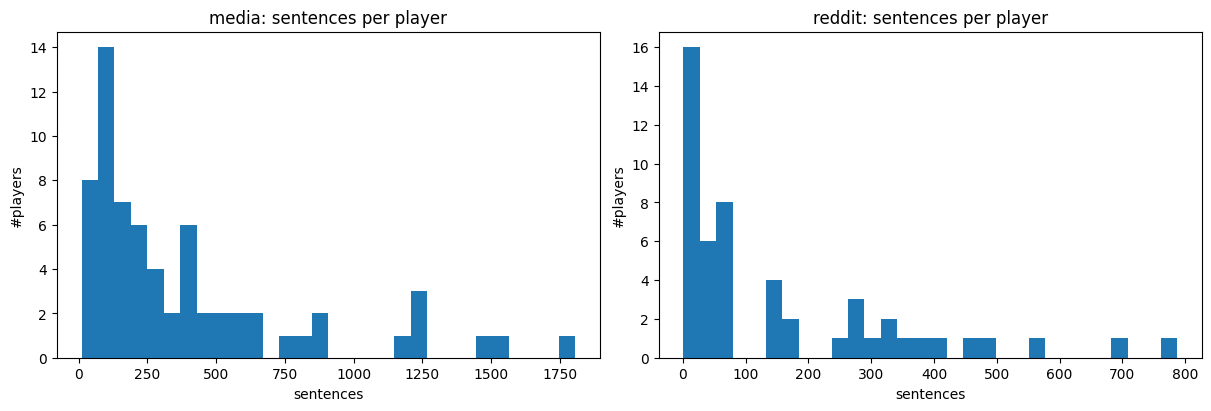

In [5]:
# Sentences per player

def sentences_per_player(df: pd.DataFrame, n: int = 100) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=['player', 'sentences'])
    counts = df.groupby('player').size().sort_values(ascending=False)
    return counts.head(n).reset_index(name='sentences')


display(sentences_per_player(media))
display(sentences_per_player(reddit))

if not all_df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    for i, (name, df) in enumerate([('media', media), ('reddit', reddit)]):
        if df.empty:
            ax[i].set_title(f"{name}: no data")
            continue
        counts = df.groupby('player').size()
        ax[i].hist(counts, bins=30)
        ax[i].set_title(f"{name}: sentences per player")
        ax[i].set_xlabel("sentences")
        ax[i].set_ylabel("#players")
    plt.show()


The “sentences per player” tables show a classic long-tail: a few players have hundreds–thousands of sentences, while many have tens.

The “compare_sources” pivot shows some players are mostly media (e.g., Jeff Green, Aaron Holiday), while some are relatively Reddit-heavy (e.g., Jaxson Hayes has more Reddit than media in our top list).
Implication: correlations/regressions can be driven by who is most talked about rather than by the underlying relationship we care about.

,n_other_persons,count
0,0,14962
1,1,7321
2,2,2372
3,3,784
4,4,272
5,5,112
6,6,59
7,7,45
8,8,15
9,9,18


,n_other_persons,count
0,0,6655
1,1,1044
2,2,280
3,3,71
4,4,29
5,5,6
6,6,6
7,7,2
8,8,1
9,10,1


Top other_persons (media):


,other_person,count
0,Thunder,192
1,James,182
2,Spurs,161
3,Kevin Durant,150
4,Anthony Davis,147
5,Giannis,136
6,Gilgeous-Alexander,135
7,Lillard,132
8,Johnson,123
9,Giannis Antetokounmpo,122


Top other_persons (reddit):


,other_person,count
0,Phil Jackson,75
1,Luka,67
2,Kobe,66
3,KD,38
4,Rudy,38
5,Giannis,33
6,Jaylen Brown,28
7,Chet,28
8,Gobert,23
9,Phil,22


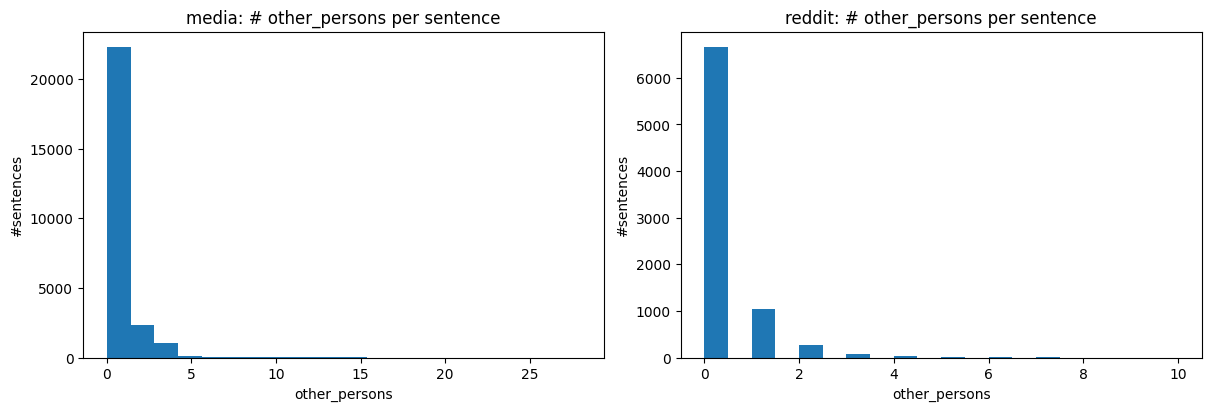

In [6]:
# Distribution of other_persons ("secondary people")

def other_person_distribution(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=['n_other_persons', 'count'])
    vc = df['n_other_persons'].value_counts().sort_index()
    return vc.reset_index(name='count').rename(columns={'index': 'n_other_persons'})


display(other_person_distribution(media).head(20))
display(other_person_distribution(reddit).head(20))

print('Top other_persons (media):')
display(top_other_persons(media, 30))
print('Top other_persons (reddit):')
display(top_other_persons(reddit, 30))

if not all_df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    for i, (name, df) in enumerate([('media', media), ('reddit', reddit)]):
        if df.empty:
            ax[i].set_title(f"{name}: no data")
            continue
        ax[i].hist(df['n_other_persons'], bins=20)
        ax[i].set_title(f"{name}: # other_persons per sentence")
        ax[i].set_xlabel("other_persons")
        ax[i].set_ylabel("#sentences")
    plt.show()


From the n_other_persons distribution:

Media: ~42.5% of sentences mention ≥1 other person.

Reddit: ~17.8% mention ≥1 other person.
Implication: attribution is harder in media (more co-mentions → more ambiguity about “who” the sentiment is directed at)

,n_players_mentioned,count
0,1,24766
1,2,1013
2,3,160
3,4,47
4,5,13
5,6,8
6,7,2
7,8,1
8,9,1


,n_players_mentioned,count
0,1,7865
1,2,197
2,3,23
3,4,6
4,5,3
5,6,1


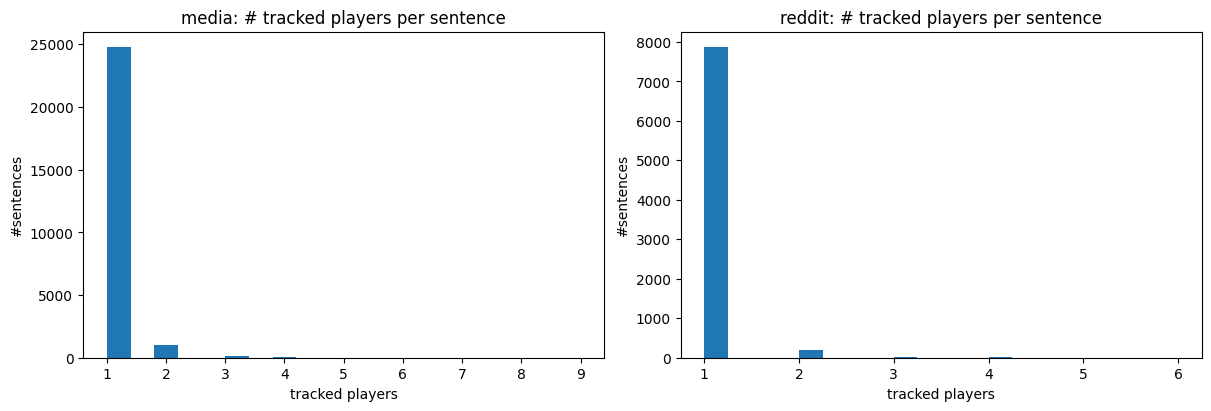

In [40]:
# Distribution of co-mentioned tracked players

def tracked_player_distribution(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=['n_players_mentioned', 'count'])
    vc = df['n_players_mentioned'].value_counts().sort_index()
    return vc.reset_index(name='count').rename(columns={'index': 'n_players_mentioned'})


display(tracked_player_distribution(media).head(20))
display(tracked_player_distribution(reddit).head(20))

if not all_df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    for i, (name, df) in enumerate([('media', media), ('reddit', reddit)]):
        if df.empty:
            ax[i].set_title(f"{name}: no data")
            continue
        ax[i].hist(df['n_players_mentioned'], bins=20)
        ax[i].set_title(f"{name}: # tracked players per sentence")
        ax[i].set_xlabel("tracked players")
        ax[i].set_ylabel("#sentences")
    plt.show()


From the n_players_mentioned distribution:

Media: ~4.8% of rows mention 2+ tracked players.

Reddit: ~2.8% mention 2+ tracked players.
Implication: you should either (a) filter multi-player sentences for clean attribution, or (b) justify how you assign sentiment to one target player when multiple appear.

In [41]:
# Top (player, other_person) co-mentions

print('Top co-mentions (media):')
display(top_pairs(media, 50))
print('Top co-mentions (reddit):')
display(top_pairs(reddit, 50))


Top co-mentions (media):


,player,other_person,count
7429,Nigel Hayes-Davis,Anthony Davis,123
8475,Shai Gilgeous-Alexander,Gilgeous-Alexander,121
969,Bruce Brown,Jaylen Brown,100
2143,Chris Paul,Paul George,96
8712,Shai Gilgeous-Alexander,Thunder,86
6198,Kevin Porter Jr.,Michael Porter Jr.,75
5407,Jeff Green,Jalen Green,69
2683,D'Angelo Russell,Russell Westbrook,65
1590,Chet Holmgren,Jalen Williams,56
3427,Devin Booker,Kevin Durant,54


Top co-mentions (reddit):


,player,other_person,count
477,Isaiah Jackson,Phil Jackson,75
454,Isaiah Jackson,Kobe,54
617,Jaxson Hayes,Rudy,29
601,Jaxson Hayes,Luka,25
359,Devin Booker,KD,23
78,Bruce Brown,Jaylen Brown,21
476,Isaiah Jackson,Phil,21
838,Myles Turner,Chet,19
565,Jaxson Hayes,Gobert,17
366,Devin Booker,Luka,14


Our top (player, other_person) pairs include patterns like:

Isaiah Jackson ↔ Phil Jackson

Jaxson Hayes ↔ Jaxon Hayes

Shai Gilgeous-Alexander ↔ “Gilgeous-Alexander” / “Gilgeous-Alexander’s”

Chris Paul ↔ Paul George
These are plausible co-mentions sometimes, but the frequency strongly suggests surname/substring collisions and inconsistent entity normalization.
Implication: treat other_persons as noisy metadata unless we clean it (otherwise it can mislead any “context-aware” analysis).

In [42]:
# Compare media vs reddit for the same player volumes

def compare_sources(all_df: pd.DataFrame, top_n: int = 30) -> pd.DataFrame:
    if all_df.empty:
        return pd.DataFrame()
    counts = all_df.groupby(['source', 'player']).size().reset_index(name='sentences')
    pivot = counts.pivot_table(index='player', columns='source', values='sentences', fill_value=0)
    pivot['total'] = pivot.sum(axis=1)
    return pivot.sort_values('total', ascending=False).head(top_n)


display(compare_sources(all_df, 30))


source,media,reddit,total
player,,,
Chris Paul,1805.0,158.0,1963.0
Devin Booker,1225.0,708.0,1933.0
Shai Gilgeous-Alexander,1495.0,364.0,1859.0
Myles Turner,1156.0,552.0,1708.0
Jeff Green,1514.0,41.0,1555.0
Bruce Brown,1253.0,268.0,1521.0
Aaron Holiday,1265.0,15.0,1280.0
Damian Lillard,886.0,373.0,1259.0
Isaiah Jackson,801.0,454.0,1255.0


In [ ]:

PLAYER = 'Shai Gilgeous-Alexander'  # edit
SOURCE = None  # None, 'media', or 'reddit'

df = all_df
if SOURCE:
    df = df[df['source'] == SOURCE]
df_p = df[df['player'] == PLAYER].copy()

print(f"rows for {PLAYER} ({SOURCE or 'all sources'}): {len(df_p):,}")
display(top_other_persons(df_p, 40))

examples = df_p[df_p['n_other_persons'] > 0][['source', 'sentence', 'other_persons']].head(20)
display(examples)
# makes sense other people around shai are mainly his teammates

rows for Shai Gilgeous-Alexander (all sources): 1,859


,other_person,count
0,Gilgeous-Alexander,123
1,Thunder,97
2,Jalen Williams,29
3,Naz Reid,21
4,Reid,17
5,Edwards,17
6,Julius Randle,16
7,Williams,16
8,Dort,16
9,Luka,13


,source,sentence,other_persons
160,media,They had some serious financial hurdles to jum...,"[Naz Reid, Julius Randle]"
209,media,"In truth, Kim Towne, a South African born woma...","[Kim Towne, Alexander Towne]"
212,media,"In January, former Pikesville High School prin...",[Eric Eiswert]
214,media,Fake Autopsy and More of Victim Austin Metcalf...,"[Fake Autopsy, Victim Austin Metcalf, Austin M..."
254,media,"I know that’s confident, but we got Kristaps (...","[Nickeil, Luke]"
255,media,We won’t put any kind of expectations on our g...,[Kobe Bufkin]
384,media,Jalen Williams and Shai Gilgeous-Alexander got...,[Jalen Williams]
721,media,"If Minnesota re-signs Julius Randle, Naz Reid ...",[Naz Reid]
722,media,If they lose Reid or Alexander-Walker (or less...,[Reid]
855,media,Minnesota Timberwolves\n-\nThe Moves: re-signe...,"[Naz Reid, Joe Ingles\n-\n]"
